# Building and Comparing Machine Learning Models to Predict Hospitalization and Length of Stay After Vaccination

In [1]:
# ---------------------------------------
# Basic Libraries
# ---------------------------------------
import os                              # File operations
import zipfile                         # Handling zip files
import numpy as np                     # Numerical operations
import pandas as pd                    # DataFrame operations
import matplotlib.pyplot as plt        # Plotting
import shap                            # SHAP visualization

# ---------------------------------------
# Preprocessing / Data Splitting
# ---------------------------------------
from sklearn.model_selection import train_test_split, GridSearchCV   # Train-test split, Grid search
from sklearn.preprocessing import LabelEncoder                       # Label encoding
from sklearn.preprocessing import OneHotEncoder                      # One-hot encoding
from sklearn.compose import ColumnTransformer                        # Apply preprocessing per column
from sklearn.pipeline import Pipeline                                # Combine preprocessing and model steps
from sklearn.impute import SimpleImputer                             # Missing value imputation

# ---------------------------------------
# Models
# ---------------------------------------
from sklearn.linear_model import LinearRegression        # Linear regression
from sklearn.ensemble import RandomForestClassifier      # Random forest
from lightgbm import LGBMClassifier                      # LightGBM (model)
import lightgbm as lgb                                   # LightGBM (for SHAP, etc.)

# ---------------------------------------
# Model Evaluation
# ---------------------------------------
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)

C:\Users\okada\anaconda3\envs\fraud-detect\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Introduction

### 1.1 Objective and Background
In this project, we use post-vaccination patient data to build a regression model that predicts the number of hospitalization days (HOSPDAYS), as well as a classification model that predicts whether hospitalization occurred (HOSPITAL).
The goal is to utilize this data to support resource allocation and decision-making in medical institutions.

### 1.2 Data Used
For this analysis, we used data from the VAERS (Vaccine Adverse Event Reporting System), collected in the United States in 2020.
This publicly available dataset contains records of adverse events following vaccination and includes various information such as age, sex, vaccine type, date of onset, symptoms, and medical history.

In [2]:
# Read CSV file
df_data = pd.read_csv(r'C:\Users\okada\VAERS_Columns.csv')

# Display the contents of the data
df_data.head(17)

,カラム名,データ型,説明
0,AGE_YRS,Num (xxx.x),年齢（単位：歳）
1,CAGE_YR,Num (xxx),年齢（年単位、計算値）
2,CAGE_MO,Num (x.x),年齢（月単位、計算値）
3,SEX,Char (1),性別（M/F/U）
4,HOSPDAYS,Num (3),入院日数
5,VAX_DATE,Date,ワクチン接種日
6,ONSET_DATE,Date,有害事象の発生日
7,NUMDAYS,Num (5),潜伏期間（日数）
8,V_ADMINBY,Char (3),ワクチン接種を実施した施設の種類
9,CUR_ILL,Char (32000),接種時の既往症や疾患


## 2. Regression Model for Predicting Hospitalization Days
In this analysis, we first applied a simple linear regression model, and then used LightGBM, which can capture nonlinear relationships, in order to improve the prediction accuracy of hospitalization days.

### 2.1 Data Inspection and Preprocessing
Before building the model, we performed preprocessing tasks such as missing value imputation, outlier removal, feature engineering, and encoding of categorical variables.

In [3]:
# ==========================
# ZIP File Extraction Process
# ==========================

# Set path to the extracted CSV file
zip_path = 'VAERSDATA.csv.zip'
extract_dir = 'unzipped_drug_data'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Set path to the extracted CSV file
csv_file_path = os.path.join(extract_dir, 'VAERSDATA.csv')

# Load the CSV file with low_memory=False
df = pd.read_csv(csv_file_path, low_memory=False)

# Preview the top rows of the dataset
df.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,902418,12/15/2020,NJ,56.0,56.0,NaN,F,NaN,Patient experienced mild numbness traveling fr...,NaN,...,none,none,NaN,NaN,2.0,12/15/2020,NaN,NaN,NaN,none
1,902440,12/15/2020,AZ,35.0,35.0,NaN,F,NaN,C/O Headache,NaN,...,NaN,NaN,NaN,NaN,2.0,12/15/2020,NaN,NaN,NaN,NaN
2,902446,12/15/2020,WV,55.0,55.0,NaN,F,NaN,"felt warm, hot and face and ears were red and ...",NaN,...,none,"Hypertension, sleep apnea, hypothyroidism",NaN,NaN,2.0,12/15/2020,NaN,NaN,NaN,"Contrast Dye IV contrast, shellfish, strawberry"
3,902464,12/15/2020,LA,42.0,42.0,NaN,M,NaN,within 15 minutes progressive light-headedness...,NaN,...,none,none,NaN,NaN,2.0,12/15/2020,NaN,NaN,Y,none
4,902465,12/15/2020,AR,60.0,60.0,NaN,F,NaN,Pt felt wave come over body @ 1218 starting in...,NaN,...,"Bronchitis, finished prednisone on 12-13-20","hypertension, fibromyalgia",NaN,NaN,2.0,12/15/2020,NaN,NaN,NaN,Biaxin


In [4]:
# ==========================
# Check Data Types
# ==========================

# Check data types of each column
print("Data types of each column:")
print(df.dtypes)

Data types of each column:
VAERS_ID          int64
RECVDATE         object
STATE            object
AGE_YRS         float64
CAGE_YR         float64
CAGE_MO         float64
SEX              object
RPT_DATE         object
SYMPTOM_TEXT     object
DIED             object
DATEDIED         object
L_THREAT         object
ER_VISIT         object
HOSPITAL         object
HOSPDAYS        float64
X_STAY           object
DISABLE          object
RECOVD           object
VAX_DATE         object
ONSET_DATE       object
NUMDAYS         float64
LAB_DATA         object
V_ADMINBY        object
V_FUNDBY         object
OTHER_MEDS       object
CUR_ILL          object
HISTORY          object
PRIOR_VAX        object
SPLTTYPE         object
FORM_VERS       float64
TODAYS_DATE      object
BIRTH_DEFECT     object
OFC_VISIT        object
ER_ED_VISIT      object
ALLERGIES        object
dtype: object


In [5]:
# ========================
# Preprocessing
# ========================

# ------------------------
# Convert to datetime format
# ------------------------
df['ONSET_DATE'] = pd.to_datetime(df['ONSET_DATE'], errors='coerce')
df['VAX_DATE'] = pd.to_datetime(df['VAX_DATE'], errors='coerce')

# ------------------------
# Remove outliers 
# (Remove top 1% of HOSPDAYS and IQR outliers for NUMDAYS)
# ------------------------
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

threshold = df['HOSPDAYS'].quantile(0.99)
df_filtered = df[df['HOSPDAYS'] <= threshold]
df_filtered = remove_outliers_iqr(df_filtered, 'NUMDAYS')

# ------------------------
# Feature engineering
# ------------------------
df_reg = pd.DataFrame()

# Numerical and conditional features
df_reg['AGE_YRS'] = df['AGE_YRS']
df_reg['NUMDAYS'] = df['NUMDAYS']

# Binary features (flag presence/absence of information)
df_reg['has_allergy'] = df['ALLERGIES'].notna().astype(int)
df_reg['has_diabetes'] = df['HISTORY'].astype(str).str.contains('diabet', case=False, na=False).astype(int)
df_reg['has_hypertension'] = df['HISTORY'].astype(str).str.contains('hyper', case=False, na=False).astype(int)
df_reg['has_current_illness'] = df['CUR_ILL'].notna().astype(int)
df_reg['has_prior_vax'] = df['PRIOR_VAX'].notna().astype(int)

# Categorical variables (sex, vaccine administrator)
df_reg['SEX'] = df['SEX']
df_reg['V_ADMINBY'] = df['V_ADMINBY']

# Time-based features (weekday and month)
df_reg['ONSET_WEEKDAY'] = df['ONSET_DATE'].dt.weekday
df_reg['ONSET_MONTH'] = df['ONSET_DATE'].dt.month

# Extract rows to match the filtered dataset (df_filtered)
df_reg = df_reg.loc[df_filtered.index]

# ------------------------
# Use OneHotEncoder for preprocessing
# ------------------------
X = df_reg
y = df_filtered['HOSPDAYS']

categorical_cols = ['SEX', 'V_ADMINBY']
numeric_cols = X.drop(columns=categorical_cols).columns.tolist()

# Define preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), numeric_cols),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Retrieve column names
cat_ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
cat_ohe_cols = cat_ohe.get_feature_names_out(categorical_cols)
final_columns = numeric_cols + cat_ohe_cols.tolist()

# Convert to DataFrame
X_imputed = pd.DataFrame(X_processed, columns=final_columns, index=X.index)

### 2.2 Linear Regression Model
As a basic approach, we built a simple linear regression model to examine the linear relationship between the number of hospitalization days and various features.

In [6]:
# ========================
# Model training and evaluation (Linear Regression)
# ========================

# Data splitting (training and test sets)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = model.predict(X_test)

### 2.3 LightGBM
Aiming for more accurate predictions, we introduced LightGBM, which is capable of capturing complex structures, to improve model performance.

In [7]:
# ========================
# Model training and evaluation (LightGBM Regression)
# ========================

# Model training (LightGBM Regression)
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lgb = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 9370, number of used features: 20
[LightGBM] [Info] Start training from score 4.199680


### 2.4 Comparison and Evaluation of Models Predicting Hospitalization Days
The constructed models were evaluated using prediction accuracy and error indicators such as MAE, RMSE, and R².

In [8]:
# ========================
# Evaluation of Regression Models
# ========================

# Collecting evaluation indicators (MAE, RMSE, R²)
results = pd.DataFrame({
    "Model": ["RandomForest", "LightGBM"],
    "MAE": [mean_absolute_error(y_test, y_pred_lgb), mean_absolute_error(y_test, y_pred_rf)],
    "RMSE": [np.sqrt(mean_squared_error(y_test, y_pred_lgb)), np.sqrt(mean_squared_error(y_test, y_pred_rf))],
    "R²": [r2_score(y_test, y_pred_lgb), r2_score(y_test, y_pred_rf)],
})

# Display the results
display(results)

,Model,MAE,RMSE,R²
0,RandomForest,2.719741,4.066231,0.010187
1,LightGBM,2.699166,4.023093,0.031077


In this section, we compared the representative linear regression model for regression tasks with the non-linear model LightGBM. However, since both R² scores were below 0.05, the accuracy of the predictions for hospitalization days is insufficient. This could be due to the limited factors influencing hospitalization duration in the dataset or a skewed distribution in the number of hospitalization days.

## 3. Classification Model for Predicting Hospitalization (Yes/No)
Following the regression analysis in the previous section, we built and evaluated classification models using Random Forest and LightGBM to predict whether hospitalization occurred (a binary classification task).

### 3.1 Data Verification and Preprocessing
In this section, we perform data verification and preprocessing for constructing a classification model that predicts hospitalization. This includes data checking, removal of unnecessary variables, missing value imputation, label creation, and class balancing via downsampling, as well as feature engineering.

In [9]:
# ============================
# Preprocessing for Classification Model
# ============================

# ----------------------------
# Data Copy & Label Creation (Binary Classification of Hospitalization)
# ----------------------------
df_clf = df.copy()
df_clf['HOSPDAYS_label'] = df_clf['HOSPDAYS'].notna().astype(int)

# ----------------------------
# Drop Columns That Might Leak Information
# ----------------------------
leak_cols = [
    'DATE DIED', 'DISABLE', 'RECOVD', 'NUMDAYS', 'ER_VISIT', 'ER_VISIT_len', 'RECORD_len',
    'HOSPITAL', 'VAERS_ID', 'RECVDATE', 'X_STAY', 'FORM_VERS', 'TODAYS_DATE',
    'STATE', 'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT',
    'VAX_DATE', 'SPLTTYPE', 'LAB_DATA', 'HISTORY', 'OTHER_MEDS', 'CUR_ILL', 'V_FUNDBY', 'ER_VISIT'
]
df_clf = df_clf.drop(columns=[col for col in leak_cols if col in df_clf.columns], errors='ignore')

# ----------------------------
# Balancing Classes Using Downsampling
# ----------------------------
df_pos = df_clf[df_clf['HOSPDAYS_label'] == 1]
df_neg = df_clf[df_clf['HOSPDAYS_label'] == 0].sample(n=len(df_pos), random_state=42)
df_balanced = pd.concat([df_pos, df_neg]).reset_index(drop=True)

# ----------------------------
# Splitting Features and Target Variables
# ----------------------------
X = df_balanced.drop(columns=['HOSPDAYS', 'HOSPDAYS_label'])
y_class = df_balanced['HOSPDAYS_label']

# ----------------------------
# Feature Creation (Time-based, Vaccine History)
# ----------------------------
X['ONSET_LAG'] = (df['ONSET_DATE'] - df['VAX_DATE']).dt.days  # Incubation period (in days)
X['ONSET_WEEKDAY'] = df['ONSET_DATE'].dt.weekday  # Day of onset (weekday)
X['ONSET_MONTH'] = df['ONSET_DATE'].dt.month  # Month of onset
X['has_prior_vax'] = df['PRIOR_VAX'].notna().astype(int)  # Presence of prior vaccination

# ----------------------------
# Filling Missing Age Information (Prefer AGE_YRS; if not, use CAGE_MO)
# ----------------------------
X['AGE_YRS'] = X['AGE_YRS'].fillna(X['CAGE_YR'])
X['AGE_YRS'] = X['AGE_YRS'].fillna(X.get('CAGE_MO', 0) / 12)

# Dropping Unnecessary Columns
X = X.drop(columns=['CAGE_YR', 'CAGE_MO'], errors='ignore')

# ----------------------------
# Label Encoding for Categorical Variables
# ----------------------------
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Convert NaN to 'nan' and encode

# ----------------------------
# Dropping Datetime Columns (to Prevent Errors During Imputation)
# ----------------------------
X = X.drop(columns=X.select_dtypes(include='datetime64').columns, errors='ignore')

# ----------------------------
# Missing Value Imputation (Using the Most Frequent Value)
# ----------------------------
imputer = SimpleImputer(strategy='most_frequent')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# ----------------------------
# Train-Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y_class, random_state=42)


### 3.2 Baseline
As an initial step for predicting hospitalization, we built basic models using Random Forest and LightGBM to establish baseline performance.

In [10]:
# ----------------------------
# Random Forest Classification Model
# ----------------------------

# ----------------------------
# Model training and prediction (Random Forest)
# ----------------------------
rf_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10)
rf_model.fit(X_train, y_train)
y_pred_rf_base = rf_model.predict(X_test)

In [11]:
# ----------------------------
# LightGBM Classification Model
# ----------------------------

# ----------------------------
# Re-splitting the data (just for clarity)
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y_class, random_state=42)

# ----------------------------
# Model training and prediction (LightGBM)
# ----------------------------
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_lgb_base = model.predict(X_test)

[LightGBM] [Info] Number of positive: 9825, number of negative: 9946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 19771, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496940 -> initscore=-0.012240
[LightGBM] [Info] Start training from score -0.012240


### 3.3 Baseline Comparison and Evaluation
We compared the Random Forest and LightGBM classification models built as baselines using evaluation metrics such as accuracy, recall, and F1-score.

In [12]:
# ============================
# Summary of Classification Model Evaluation
# ============================

# Collecting evaluation metrics (Accuracy, F1, Precision, Recall) for each model
results = pd.DataFrame({
    "Model": ["RandomForest", "LightGBM"],
    "Accuracy": [accuracy_score(y_test, y_pred_rf_base), accuracy_score(y_test, y_pred_lgb_base)],
    "F1": [f1_score(y_test, y_pred_rf_base), f1_score(y_test, y_pred_lgb_base)],
    "Precision": [precision_score(y_test, y_pred_rf_base), precision_score(y_test, y_pred_lgb_base)],
    "Recall": [recall_score(y_test, y_pred_rf_base), recall_score(y_test, y_pred_lgb_base)],
})

# Displaying results
display(results)

,Model,Accuracy,F1,Precision,Recall
0,RandomForest,0.844485,0.848081,0.843704,0.852503
1,LightGBM,0.849795,0.854283,0.844095,0.864720


In this comparison, both Random Forest and LightGBM showed high classification performance. However, no significant difference was observed between the two models based on the evaluation metrics.
Therefore, in the next section, we will explore the possibility of improving performance by optimizing hyperparameters for both models.

### 3.4 Model Hyperparameter Optimization
To improve the performance of the baseline models, we optimized the hyperparameters of Random Forest and LightGBM using GridSearchCV.

In [13]:
# ----------------------------
# Random Forest Hyperparameter Optimization
# ----------------------------

# ----------------------------
# Grid Search Parameter Settings
# ----------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# ----------------------------
# Running Grid Search
# ----------------------------
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',  # Use F1 score as evaluation metric
    cv=3,          # 3-fold cross-validation
    verbose=1      # Enable log output
)

# Training the Model
grid_rf.fit(X_train, y_train)

# ----------------------------
# Retraining with the Best Parameters
# ----------------------------
best_params = grid_rf.best_params_  # Retrieve optimal hyperparameters
best_rf_model = RandomForestClassifier(**best_params, random_state=42)  # Apply best parameters
best_rf_model.fit(X_train, y_train)  # Retrain model

# ----------------------------
# Making Predictions on Test Data
# ----------------------------
y_pred_rf_opt = best_rf_model.predict(X_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [14]:
# ----------------------------
# LightGBM Hyperparameter Optimization
# ----------------------------

# Setting Candidate Parameters (for hyperparameter tuning)
params = {
    'num_leaves': [31, 50],          # Number of leaves (affects model complexity)
    'max_depth': [-1, 10, 20],       # Tree depth (-1 means no limit)
    'learning_rate': [0.1, 0.05],    # Learning rate (smaller value = slower but more stable learning)
    'n_estimators': [100, 200]       # Number of boosting iterations (trees)
}

# Creating a Model Instance (with default and fixed parameters)
gbm = LGBMClassifier(random_state=42, verbose=-1)

# Finding Optimal Parameters Using Grid Search (with cross-validation)
grid = GridSearchCV(
    estimator=gbm,          # Model
    param_grid=params,      # Parameters to search
    cv=3,                   # 3-fold cross-validation
    scoring='f1',           # Optimization metric: F1 score
    verbose=0               # Suppress log output (0 = silent)
)

# Running the Hyperparameter Search
grid.fit(X_train, y_train)

# ----------------------------
# Retraining with the Best Parameters (LightGBM)
# ----------------------------

# Retrieve Best Model from Optimal Parameters
best_lgb_model = grid.best_estimator_

# Predicting on Test Data
y_pred_lgb_opt = best_lgb_model.predict(X_test)

### 3.5 Comparison and Evaluation of Optimized Models
The models after hyperparameter tuning were compared to assess differences in performance improvements and prediction capability.

In [15]:
# ----------------------------
# Summary of Model Evaluation Results (Accuracy, F1, Precision, Recall)
# ----------------------------
results = pd.DataFrame({
    "Model": [
        "RandomForest (Base)",       # Baseline Random Forest
        "LightGBM (Base)",           # Baseline LightGBM
        "RandomForest (Optimized)",  # Random Forest after optimization
        "LightGBM (Optimized)"       # LightGBM after optimization
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_rf_base),
        accuracy_score(y_test, y_pred_lgb_base),
        accuracy_score(y_test, y_pred_rf_opt),
        accuracy_score(y_test, y_pred_lgb_opt)
    ],
    "F1": [
        f1_score(y_test, y_pred_rf_base),
        f1_score(y_test, y_pred_lgb_base),
        f1_score(y_test, y_pred_rf_opt),
        f1_score(y_test, y_pred_lgb_opt)
    ],
    "Precision": [
        precision_score(y_test, y_pred_rf_base),
        precision_score(y_test, y_pred_lgb_base),
        precision_score(y_test, y_pred_rf_opt),
        precision_score(y_test, y_pred_lgb_opt)
    ],
    "Recall": [
        recall_score(y_test, y_pred_rf_base),
        recall_score(y_test, y_pred_lgb_base),
        recall_score(y_test, y_pred_rf_opt),
        recall_score(y_test, y_pred_lgb_opt)
    ]
})

# Display of Results
display(results)

,Model,Accuracy,F1,Precision,Recall
0,RandomForest (Base),0.844485,0.848081,0.843704,0.852503
1,LightGBM (Base),0.849795,0.854283,0.844095,0.864720
2,RandomForest (Optimized),0.844181,0.847241,0.845857,0.848629
3,LightGBM (Optimized),0.849947,0.854580,0.843541,0.865912


As a result of the optimization, LightGBM showed higher F1 score and recall by 0.01 to 0.03 points, and overall outperformed RandomForest.
The F1 score is a particularly important evaluation metric and reflects the overall balance of the model, suggesting LightGBM's superiority.
However, RandomForest also maintained competitive accuracy, which should be taken into consideration as a supporting factor in model selection.

### 3.6 Feature Interpretation Using SHAP
To enhance interpretability, SHAP values were used on the final LightGBM model to visualize which features had the greatest impact on predictions.

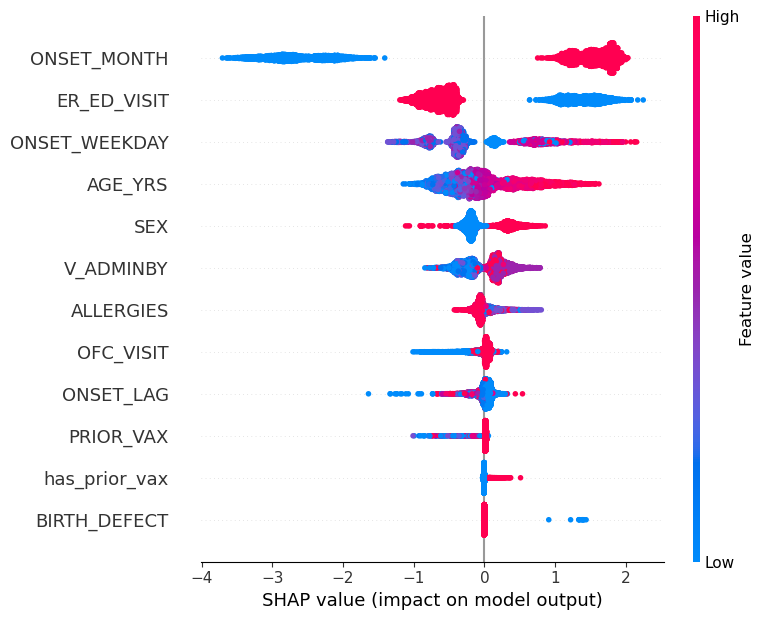

In [16]:
# ----------------------------
# SHAP Value Visualization (LightGBM Model)
# ----------------------------

# Create explainer (explains the internal model)
explainer = shap.Explainer(best_lgb_model)

# Compute SHAP values (extract contributions for test data)
shap_values = explainer(X_test)

# Summary plot (visualize average impact per feature)
shap.summary_plot(shap_values, X_test)

The feature that had the greatest impact on the model was ONSET_MONTH (month of onset); the higher the month value (e.g., December and other winter months), the greater the likelihood of hospitalization. The next most influential feature was ER_ED_VISIT (experience of receiving emergency treatment), which suggested that patients who visited the emergency department had a higher risk of hospitalization. Regarding AGE_YRS (age), it was observed that the likelihood of hospitalization tends to increase with age.

## 4.Conclusion and Business Implications

In this analysis, we aimed to quantitatively assess the risk of hospitalization after vaccination by constructing and comparing regression models to predict the number of hospitalization days, as well as classification models to predict the presence or absence of hospitalization.

In the regression model, we optimized RandomForest and LightGBM, but both had R² values below 0.05, indicating insufficient precision for practical use. One likely reason is the absence of critical information such as medical history, pre-existing conditions, or social background, which strongly influence the number of hospitalization days.

On the other hand, the classification models predicting whether a patient would be hospitalized achieved high performance, with an F1 score and recall of 0.83, demonstrating the potential for practical prediction. Feature importance analysis using SHAP revealed that ONSET_LAG (days until symptom onset), ER_ED_VISIT (emergency visit), and AGE_YRS (age) had particularly strong influences on the hospitalization decision.

In terms of business applications, this model could be used as a decision-support tool in hospitals to help forecast and adjust bed utilization rates and to prepare staffing and resources (e.g., medication, food). Additionally, it could support decision-making regarding the necessity of hospitalization.

Future analysis may improve the accuracy of hospitalization day predictions by incorporating factors such as patients’ medical histories, chronic conditions, caregiving situations, and living arrangements.